In [1]:
import inferpy as inf
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
@inf.probmodel
def linear_reg(d):
    w0 = inf.Normal(0, 1, name="w0")
    w = inf.Normal(np.zeros([d, 1]), 1, name="w")

    with inf.datamodel():
        x = inf.Normal(tf.ones(d), 2, name="x")
        y = inf.Normal(w0 + x @ w, 1.0, name="y")

In [3]:
@inf.probmodel
def qmodel(d):
    qw0_loc = inf.Parameter(0., name="qw0_loc")
    qw0_scale = tf.math.softplus(inf.Parameter(1., name="qw0_scale"))
    qw0 = inf.Normal(qw0_loc, qw0_scale, name="w0")

    qw_loc = inf.Parameter(np.zeros([d, 1]), name="qw_loc")
    qw_scale = tf.math.softplus(inf.Parameter(tf.ones([d, 1]), name="qw_scale"))
    qw = inf.Normal(qw_loc, qw_scale, name="w")

In [4]:
# create an instance of the model
m = linear_reg(d=2)
q = qmodel(2)

In [5]:
# create toy train data
N = 1000
data = m.prior(["x", "y"], data={"w0": 0, "w": [[2], [1]]}, size_datamodel=N).sample()
x_train = data["x"]
y_train = data["y"]

In [6]:
# set and run the inference
VI = inf.inference.VI(qmodel(2), epochs=10000)
m.fit({"x": x_train, "y": y_train}, VI)


 0 epochs	 52972.28515625....................
 200 epochs	 10275.595703125....................
 400 epochs	 67503.8515625....................
 600 epochs	 12255.0439453125....................
 800 epochs	 16939.837890625....................
 1000 epochs	 17516.859375....................
 1200 epochs	 23412.107421875....................
 1400 epochs	 10594.9287109375....................
 1600 epochs	 6861.873046875....................
 1800 epochs	 10786.71484375....................
 2000 epochs	 6101.9345703125....................
 2200 epochs	 11236.6630859375....................
 2400 epochs	 7963.16015625....................
 2600 epochs	 12368.654296875....................
 2800 epochs	 11602.6240234375....................
 3000 epochs	 11974.2734375....................
 3200 epochs	 6126.74755859375....................
 3400 epochs	 8237.98046875....................
 3600 epochs	 7064.48876953125....................
 3800 epochs	 7711.18359375....................
 4000 epochs	 90

In [8]:
# extract the parameters of the posterior
m.posterior(["w", "w0"]).parameters()

{'w0': {'name': 'w0',
  'allow_nan_stats': True,
  'validate_args': False,
  'scale': 0.15745752,
  'loc': -0.0063336673},
 'w': {'name': 'w',
  'allow_nan_stats': True,
  'validate_args': False,
  'scale': array([[0.12546003],
         [0.11412356]], dtype=float32),
  'loc': array([[2.000915  ],
         [0.99964625]], dtype=float32)}}

In [37]:
# create toy test data
N = 1000
data_test = m.prior(["x", "y"], data={"w0": 0, "w": [[2.5], [1]]}, size_datamodel=N).sample()
x_test = data_test["x"]
y_test = data_test["y"]

Text(0.5, 1.0, 'Bayesian Linear Regression')

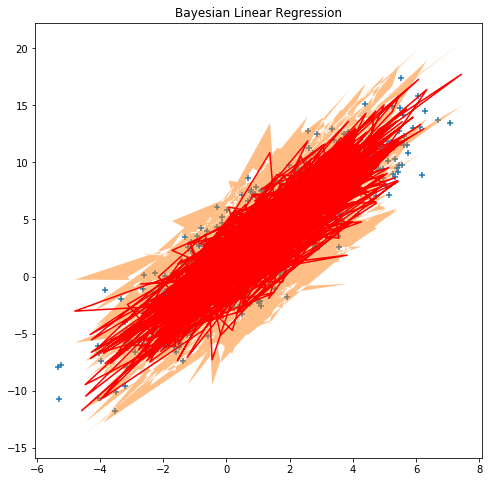

In [41]:
#x_test = np.linspace(-20.5, 20.5, NSAMPLE).reshape(-1, 1)

plt.figure(figsize=(8, 8))

y_pred_list = []
for i in range(100):
    y_test = m.posterior_predictive(["y"], data = {"x": x_test}).sample()
    y_pred_list.append(y_test)

y_preds = np.concatenate(y_pred_list, axis=1)

y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

plt.plot(x_test[:,0], y_mean, 'r-', label='Predictive mean');
plt.scatter(x_train[:,0], y_train, marker='+', label='Training data')
plt.fill_between(x_test[:,0].ravel(),
                 y_mean + 2 * y_sigma,
                 y_mean - 2 * y_sigma,
                 alpha=0.5, label='Epistemic uncertainty')
#plt.xticks(np.arange(-20., 20.5, 4))
plt.title('Bayesian Linear Regression')

In [42]:
y_preds.shape

(1000, 100)

In [43]:
y_preds

array([[5.006813  , 1.9733986 , 3.503396  , ..., 4.9159374 , 1.4305253 ,
        4.3093266 ],
       [1.8525039 , 2.4830613 , 2.5556278 , ..., 2.977002  , 2.0015237 ,
        2.0865736 ],
       [4.363532  , 5.040534  , 6.0777783 , ..., 5.0551124 , 4.127759  ,
        4.412161  ],
       ...,
       [2.1233702 , 0.831238  , 0.44526702, ..., 0.21349609, 2.8687835 ,
        0.27859545],
       [7.5211616 , 7.691222  , 7.822     , ..., 7.4636927 , 7.299159  ,
        6.076239  ],
       [3.8213732 , 3.981018  , 2.6631    , ..., 3.8538158 , 4.969659  ,
        3.3928304 ]], dtype=float32)